# LLMs Translation Pipeline


This would be a pipeline for Machine Translation from lux to english including data pre-processing, translation and data post-processing.

1. Context information should be included inside each transation sample and sliding windows will be used.
2. Make full use of the model's hallucination properties to make more samples. (Different temperatures: 0.1,0.5,0.9,1.3)
3. Clean the models' output and check the correcteness of the models' output. (Corprus Checking)

## Data pre-processing

In [1]:
import json
import pandas as pd
from utils.utils_nlp import split_paragraph


def load_data(file_path, label):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_data = json.loads(line)
            json_data['label'] = label
            data.append(json_data)
    return data
    
train_data = load_data('data/NC_lux/train.json', 'train')
test_data = load_data('data/NC_lux/test.json', 'test')
dev_data = load_data('data/NC_lux/dev.json', 'dev')
all_data = train_data + test_data + dev_data

NC_lux_df = pd.DataFrame(all_data)
NC_lux_df["length"] = NC_lux_df["text"].apply(len)
NC_lux_df.head(1)


,label,text,length
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,899


In [2]:
# Drop Duplicates
original_len = len(NC_lux_df)
print("Original length:", original_len)
NC_lux_df.drop_duplicates(subset=['text'], inplace=True)
new_len = len(NC_lux_df)
print("New length after dropping duplicates:", new_len)
dropped_count = original_len - new_len
print("Number of dropped duplicates:", dropped_count)

Original length: 10052
New length after dropping duplicates: 10042
Number of dropped duplicates: 10


In [3]:
import re

max_length = int(1024 * 0.75) # Max context length * token rate

def chunk_sentence(sentence, max_length):
    chunks = []
    for i in range(0, len(sentence), max_length):
        chunk = sentence[i:i + max_length].strip()
        chunks.append(chunk)
    return chunks

def split_and_slide(text, sentence_window, max_length):
    sentences = re.split(r'(?<=[.!?;…]) +', text)
    sub_sentences = []
    
    for i in range(len(sentences)):
        window_size = sentence_window

        # Split sentences by using
        while window_size > 0:
            sub_sentence = ' '.join(sentences[i:i + window_size])
            if len(sub_sentence) <= max_length:
                sub_sentences.append(sub_sentence.strip())
                break
            window_size -= 1
        # Check 
        if window_size == 0 and len(sub_sentence) > max_length:
            long_sentence = sentences[i].strip()
            sub_sentences.extend(chunk_sentence(long_sentence, max_length))
    return sub_sentences

sentence_window = 3 # Needs to be determined

NC_lux_df['sub_sentences'] = NC_lux_df['text'].apply(lambda x: split_and_slide(x, sentence_window, max_length))
df_exploded = NC_lux_df.explode('sub_sentences')
df_exploded = df_exploded.drop(columns=['text'])

df_exploded = df_exploded.rename(columns={'sub_sentences': 'text'})
df_exploded['text'] = df_exploded['text'].astype(str)
df_exploded["length"] = df_exploded["text"].apply(len)



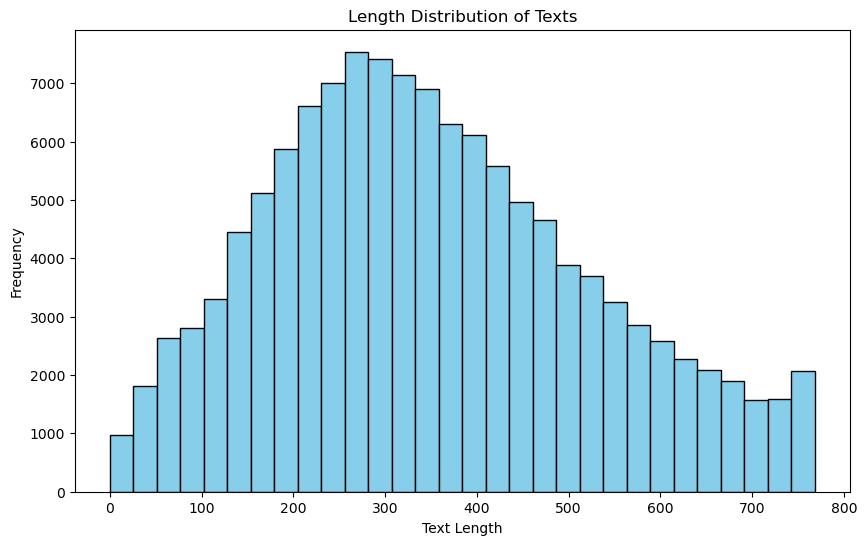

In [4]:
import matplotlib.pyplot as plt

df_exploded["length"] = df_exploded["text"].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df_exploded["length"], bins=30, color='skyblue', edgecolor='black')
plt.title("Length Distribution of Texts")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

# Inference Modeling


|  Models |  Luxembourgish to English |  Luxembourgish to French | Luxembourgish to  German |
|:-------:|:-------:|:-------:|:-------:|
|  Mixtral 8*22B  |  Yes  |  Yes  |  Yes  |
|  Llama-3-4B  |  Yes  |  Yes  |  Yes  |
|  ChatGPT 3.5-Turbo |  Yes  |  Yes  |  Yes  |

In [ ]:
prompt_template = """Please translate the following {language_1} text into {language_2}. Please answer me with only translated text!

---------------------------------- Text to be translated ----------------------------------

{Text}

---------------------------------- Text to be translated ----------------------------------

"""

df_exploded["prompt"] = df_exploded["text"].apply( lambda text: prompt_template.format(language_1="Luxembourgish", language_2="English", Text=text))

In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig,
    pipeline,
)
from tqdm import tqdm
import pandas as pd
import argparse
import torch
import numpy as np
from datetime import datetime
import time

def initialize_pipeline(model_config_dict):
    model_path = model_config_dict["CURRENT_RUNNING_MODEL"]
    if not model_path:
        raise ValueError("CURRENT_RUNNING_MODEL is not set")
    load_in_4bit,load_in_8bit = model_config_dict["CURRENT_LOAD_IN_4BIT"],model_config_dict["CURRENT_LOAD_IN_8BIT"]

    if model_config_dict["IF_LOADING_QUANTIZATION"]:
        nf4_config = BitsAndBytesConfig(load_in_4bit=load_in_4bit, load_in_8bit=load_in_8bit,bnb_4bit_compute_dtype=torch.float16,)
    else:
        nf4_config = None

    generation_config = GenerationConfig.from_pretrained(model_path)
    # Sampling Methods Configuration
    generation_config.do_sample = True
    generation_config.max_length = 1024
    generation_config.pad_token_id = 0
    generation_config.top_p = 0.9
    generation_config.temperature = 0.9
    generation_config.max_new_tokens = 512
    dynamic_text_pipeline = pipeline("text-generation", model=model_path, torch_dtype=torch.float32, device_map="auto")
    dynamic_text_pipeline.model.generation_config = generation_config
    return dynamic_text_pipeline

def generate_text(pipeline, prompt):
    messages = [
        {"role": "system", "content": ""},
        {"role": "user", "content": prompt},
    ]
    response = pipeline(prompt)[0]["generated_text"][-1]
    return response


model_config_dict = {
    "CURRENT_RUNNING_MODEL": "mt_luxembourgish/meta-llama/Llama-3.2-3B-Instruct",
    "IF_LOADING_QUANTIZATION": False,
    "CURRENT_LOAD_IN_4BIT": False,
    "CURRENT_LOAD_IN_8BIT": False
}
pipeline = initialize_pipeline(model_config_dict)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Run inference
from datetime import datetime


pbar = tqdm(total=len(df_exploded))
pbar.n = 0; pbar.last_print_n =0, pbar.refresh()

current_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
for index, row in df_exploded.iterrows():
        updated_row = row.copy()
        updated_row["generated_response"] = generate_text(pipeline=pipeline, prompt=updated_row["prompt"])
        updated_dataframe = pd.DataFrame([updated_row])
        if times == 0:
            updated_dataframe.to_csv( f"results/translation_{current_time}", index=False, mode="w", header=True)
        else:
            updated_dataframe.to_csv( f"results/translation_{current_time}", index=False, mode="a", header=False)
        pbar.update(1)
        times = times + 1